# Conditional variational autoencoder


Install the correct version of TensorFlow

In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.14

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
  Att

Import all the libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K

## Data

Load MNIST dataset

In [3]:
def load_mnist():
  # load
  mnist_dataset = mnist.load_data()
  (trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
  (X_train, y_train) = trainset
  (X_test, y_test) = testset
  # preprocess
  X_train = X_train.astype('float32')
  X_train /= 255
  X_test = X_test.astype('float32')
  X_test /= 255
  # Flatten - VAE will be made as fully-connected network
  X_train_fl = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))
  X_test_fl = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))
  return X_train_fl, y_train, X_test_fl, y_test

In [4]:
X_train, y_train, X_test, y_test = load_mnist()

11490434/11490434 [==============================] - 2s 0us/step


Show data

In [5]:
def show_images(X, n_images=4):
  fig = plt.figure()
  for i in range(n_images):
    fig.add_subplot(1, n_images, i+1)
    X_plot = X[i].reshape((28,28))
    plt.imshow(X_plot, cmap='gray')
  plt.show()

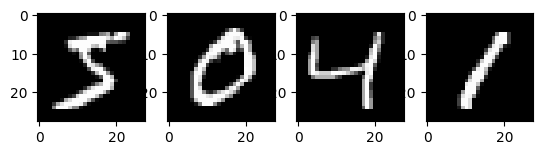

In [6]:
show_images(X_train, n_images=4)

Convert labels to one-hot

In [7]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## Model

Network parameters

In [8]:
input_size = 28*28
optimizer = 'adam'
batch_size=250
epochs=50

intermediate_dim = 512
latent_dim = 2

n_classes = y_train_one_hot.shape[1]

Build an encoder. Make sure that images and labels are concatenated before passing them to intermediate layer.

In [9]:
from tensorflow.keras.layers import Concatenate

# Define encoder input
X = Input(shape=(input_size,))
label = Input(shape=(n_classes,))

concatenated_input = Concatenate()([X, label])

intermediate_enc = Dense(intermediate_dim, activation='relu')(concatenated_input)
# last encoding layer should output parameters of the Gaussian distribution - mean and variance
z_mean = Dense(latent_dim, name='z_mean')(intermediate_enc)
z_log_var = Dense(latent_dim, name='z_log_var')(intermediate_enc)  # this is the natural logarithm of the variance (log(sigma^2))

Write a function for sampling from Gaussian, and make a Lambda layer.
You should merge sampled z with the label and instantiate an encoder model.

In [10]:
# function for sampling from the learned distribution

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    # Sample epsilon = N(0,I)
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = tf.random.normal(shape=(batch, dim))
    # Put epsilon to the learned distribution
    return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

# Lambda layer - use user-defined function as a Keras layer
z = Lambda(sampling, name='z')([z_mean, z_log_var])
# merge sample with label
z_label_merged = Concatenate()([z, label])

# instantiate encoder model
encoder = Model([X, label], [z_mean, z_log_var, z, z_label_merged], name='encoder')

Build decoder model. Define an input for a decoder. Instantiate decoder and VAE models.

In [11]:
# build decoder model
latent_inputs = Input(shape=(latent_dim + n_classes,), name='z_sampling')
intermediate_dec = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_size, activation='sigmoid')(intermediate_dec)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
# connect encoder and decoder
outputs = decoder(encoder([X, label])[3])
vae = Model([X, label], outputs, name='vae_mlp')

Make custom loss - MSE + KL. Add the formula for reconstruction loss to the code below. Be careful, only input image is reconstructed, and not the label part.

In [12]:
# Loss - MSE + KL divergence
from tensorflow.keras.losses import MSE

# TODO - add the formula for reconstruction loss
reconstruction_loss = MSE(X, outputs)
# MSE is mean over dimensions, and KL loss is sum over dimensions
# Therefore, we need to multiply MSE by the number of dimensions
reconstruction_loss *= input_size
# Calculate KL divergence between 2 multivariate Gaussians - N(z_mean, z_var) and N(0,1)
kl_loss = tf.math.exp(z_log_var) + tf.math.square(z_mean) - 1 - z_log_var
kl_loss = tf.math.reduce_sum(kl_loss, axis=-1)
kl_loss *= 0.5

vae_loss = tf.math.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer)

Train VAE with shuffling and validation split of 0.2

In [13]:
history = vae.fit([X_train, y_train_one_hot],
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2)

Epoch 1/50
192/192 [==============================] - 6s 27ms/step - loss: 56.2191 - val_loss: 39.5625
Epoch 2/50
192/192 [==============================] - 6s 32ms/step - loss: 37.6764 - val_loss: 35.6601
Epoch 3/50
192/192 [==============================] - 5s 25ms/step - loss: 35.2073 - val_loss: 34.1266
Epoch 4/50
192/192 [==============================] - 5s 27ms/step - loss: 34.0342 - val_loss: 33.2090
Epoch 5/50
192/192 [==============================] - 8s 43ms/step - loss: 33.3741 - val_loss: 32.7626
Epoch 6/50
192/192 [==============================] - 5s 27ms/step - loss: 32.8975 - val_loss: 32.3389
Epoch 7/50
192/192 [==============================] - 7s 38ms/step - loss: 32.5767 - val_loss: 32.1196
Epoch 8/50
192/192 [==============================] - 5s 26ms/step - loss: 32.3097 - val_loss: 31.8853
Epoch 9/50
192/192 [==============================] - 8s 39ms/step - loss: 32.0988 - val_loss: 31.6910
Epoch 10/50
192/192 [==============================] - 5s 26ms/step - los

Plot the training loss

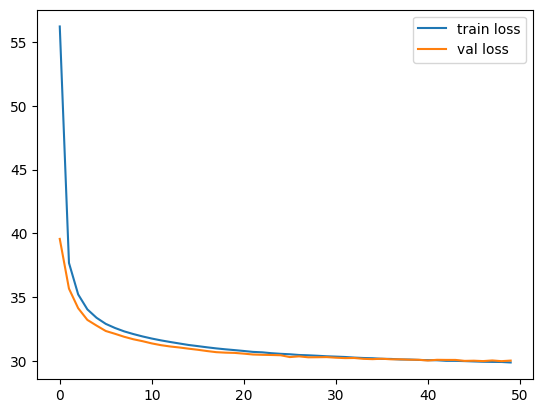

In [14]:
def plot_losses(history):
    losses = history.history
    plt.plot(losses['loss'], label='train loss')
    plt.plot(losses['val_loss'], label='val loss')
    plt.legend()
    plt.show()

plot_losses(history)

## Results

Reconstruct the test images, plot 10 of them.

313/313 [==============================] - 2s 4ms/step


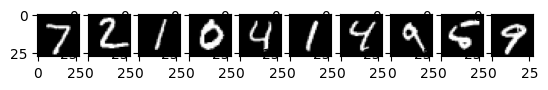

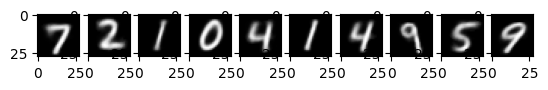

In [15]:
# Reconstruct the test images
decoded_images = vae.predict([X_test, y_test_one_hot])

def plot_orig_and_rec(orig_images, decoded_images, n_images):
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(orig_images[i].reshape(28,28), cmap='gray')
    plt.show()
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(decoded_images[i].reshape(28,28), cmap='gray')
    plt.show()

plot_orig_and_rec(X_test, decoded_images, n_images=10)


Generate 10 new images, one for each class.

1/1 [==============================] - 0s 39ms/step


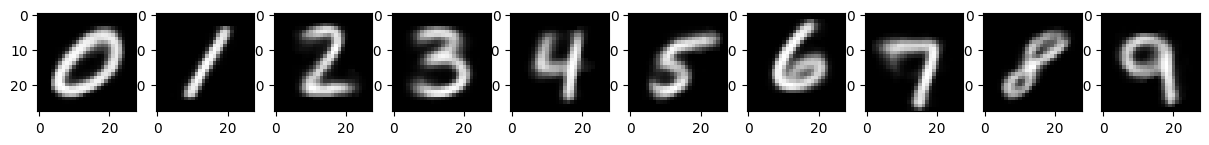

In [16]:
n_images = 10
z_gen = np.random.normal(size=(n_images,2))
labels_gen = np.identity(n_classes)

# Generate 10 new images

z_labels_gen = np.concatenate((z_gen, labels_gen), axis=1)
x_gen = decoder.predict(z_labels_gen)

fig = plt.figure(figsize=(15, 15))
for i in range(n_images):
    fig.add_subplot(1, n_images, i+1)
    plt.imshow(x_gen[i].reshape(28,28), cmap='gray')
plt.show()

Visualize the latent space

313/313 [==============================] - 1s 3ms/step


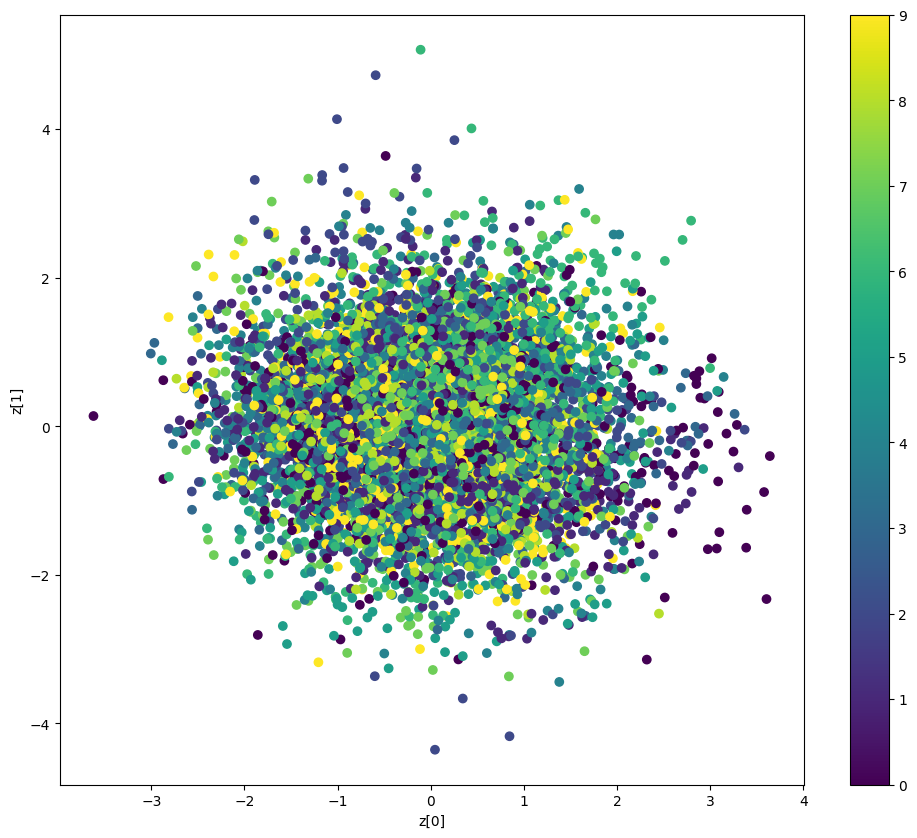

In [17]:
# Get z_mean values for whole test data
z_mean, _, _, _ = encoder.predict([X_test, y_test_one_hot])

plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Display a 2D manifold of digit '2'. It will show the variations of the digit throughout the space.

1/1 [==============================] - 0s 25ms/step


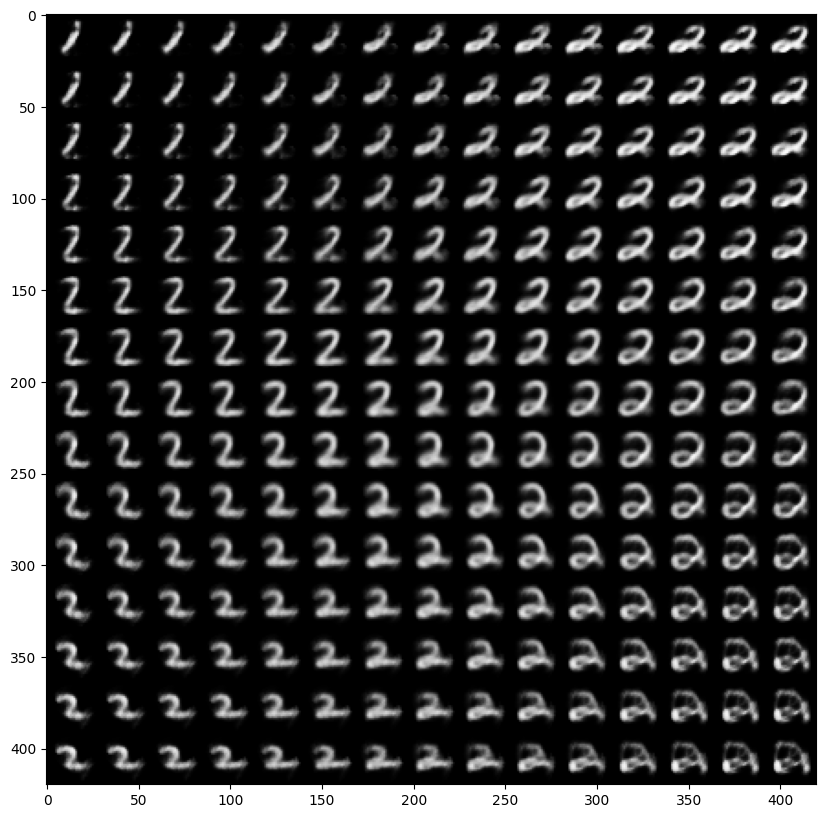

In [18]:
# display a 2D manifold of the digits
digit_label = 2
digit_label_one_hot = np.zeros((1, n_classes))
digit_label_one_hot[0][digit_label] = 1

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_label_concat = np.concatenate((z_sample, digit_label_one_hot), axis=1)
        x_decoded = decoder.predict(z_label_concat)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

Display a 2D manifold of digit '3'. It will show the variations of the digit throughout the space.

1/1 [==============================] - 0s 23ms/step


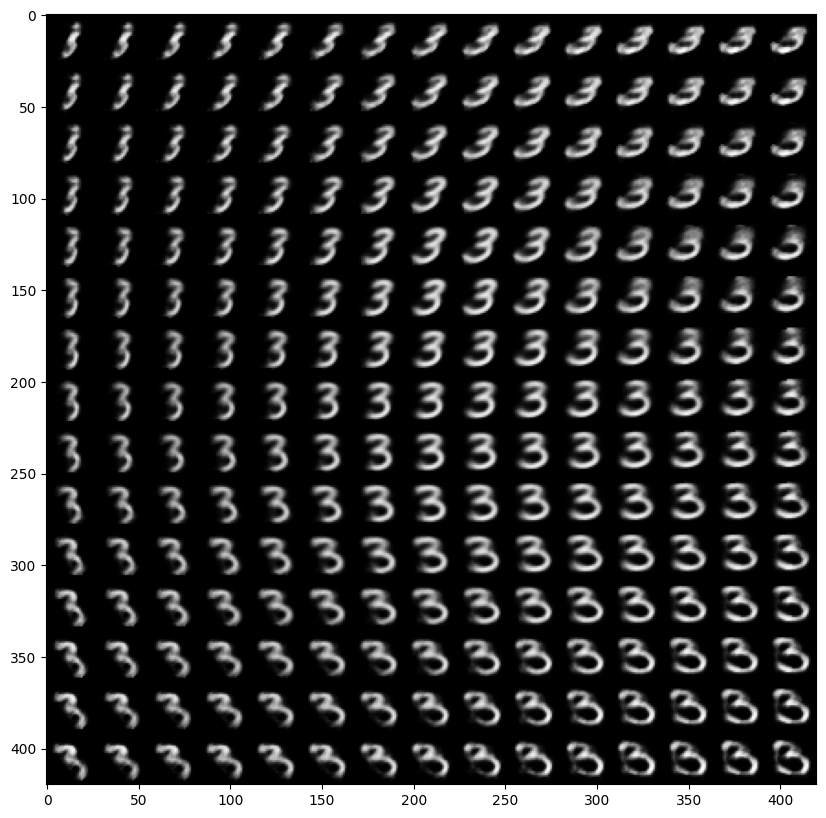

In [19]:
# display a 2D manifold of the digits
digit_label = 3
digit_label_one_hot = np.zeros((1, n_classes))
digit_label_one_hot[0][digit_label] = 1

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_label_sample = np.concatenate((z_sample, digit_label_one_hot), axis=1)
        x_decoded = decoder.predict(z_label_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()